# Human RNA editing landscape of REDIportal (GPU-based)

### Part I Clustering all 21-mers feature in REDIportal (human, hg38)

---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

**Notation: We require a table with unique 21-mers sequences, this step was ignore in the notebook.**

Please download the raw table (`TABLE1_hg38.txt` from REDIportal), then use the following command lines to generate the table:

\# Add flanking 10-nt sequences from reference genome downloaded from UCSC. `REDIportal_hg38.F10.csv` is what we want.

`python REDIportal_get_fasta.py hg38.fa TABLE1_hg38.txt REDIportal_hg38.F10.csv`

\# Collapse duplicated 21-mers.

`python collapse_overrepresent_sequences.ATCG.py REDIportal_hg38.F10.csv` 

\# Then we get `REDIportal_hg38.F10.level1.ATCG.csv`, what we need in the subsequent analysis.

\# We also require `REDIportal_hg38.F10.csv` in the analysis.

## Hardware

- Sytem: Ubuntu 18.04.5 LTS
- CPU: Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz (12 cores)
- Disk: SAMSUNG MZ7LH960HAJR-00005 (SSD)
- RAM: 64G(32Gx2) DDR4 2666MHz
- GPU: RTX2080Ti (Driver Version: 495.29.05, CUDA Version: 11.5)

## Container Environment

**RAPIDS 21.12** (see https://rapids.ai/start.html)
- Ubuntu 20.04
- All packages
- Python 3.8
- CUDA 11.5

## 0. Configure the environment

In [1]:
import numpy as np
import pandas as pd
from cuml import UMAP
from sklearn.preprocessing import OneHotEncoder
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tracemalloc

tracemalloc.start()

import time
time0 = time.time()

In [2]:
enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCG"])

def onehot_enc(seq):
    seq = [[i] for i in seq]
    return enc.transform(seq).toarray().reshape(-1)

In [4]:
def get_table_and_onehot(fn, REP_level=None):
    onehot_input = []
    
    df = pd.read_csv(fn, index_col=0, header=0)
    if REP_level is not None:
        df = df.loc[df["type"]==REP_level]
    print(df.shape)
    
    for seq in df["motif_F10"]:
            onehot_input.append(onehot_enc(seq))
    onehot_input = np.array(onehot_input)
    print(onehot_input.shape)
    
    return df, onehot_input

## 1. Load data from deduplicated table

**It takes one hour to load the file. If you already have onehot encoded file, load it directly.**

In [ ]:
onehot_input = np.load('./onehot.all_kmers.npy')

In [ ]:
import warnings
# long time...
warnings.filterwarnings('ignore')

time0 = time.time()
df, onehot_input = get_table_and_onehot("./REDIportal_hg38.F10.collapse.level1.ATCG.csv", REP_level=None)
print("Data loaded: {} sec".format(time.time()-time0))
current, peak = tracemalloc.get_traced_memory()
current = current/1024./1024.
peak = peak/1024./1024.
print("RAM:")
print("Current: {} MB".format(current))
print("Peak: {} MB".format(peak))
print(df.head())
print("===================================")


'''
Expected output:
(5081915, 10)
(5081915, 84)
Data loaded: 3560.8952593803406 sec
RAM:
Current: 1454.188208580017 MB
Peak: 3145.140151977539 MB
            key Region  Position Strand Ref Ed type      repeat  \
0  chr1@87158@-   chr1     87158      -   T  C  ALU  SINE/AluJo   
1  chr1@87168@-   chr1     87168      -   T  C  ALU  SINE/AluJo   
2  chr1@87171@-   chr1     87171      -   T  C  ALU  SINE/AluJo   
3  chr1@87189@-   chr1     87189      -   T  C  ALU  SINE/AluJo   
4  chr1@87218@-   chr1     87218      -   T  C  ALU  SINE/AluJo   

               motif_F10  collapse  
0  ACTGCACTCCAGCCTGGGTGA     False  
1  TGGTCACACCACTGCACTCCA     False  
2  CCATGGTCACACCACTGCACT     False  
3  GGTTGAGGCCACAGTGAGCCA     False  
4  CTGAGGTGGTAGGATCACTTG     False  
===================================
'''

(5081915, 10)


In [7]:
with open('onehot.all_kmers.npy', 'wb') as f:
    np.save(f, onehot_input)

## 2. UMAP with cuML

In [6]:
time0 = time.time()
umap_2d = UMAP(init="random", random_state=42, min_dist=0.01, n_neighbors=20)
proj_2d = umap_2d.fit_transform(onehot_input)
print("UMAP finished: {} sec".format(time.time()-time0))

time0 = time.time()
df["X"] = proj_2d[:, 0]
df["Y"] = proj_2d[:, 1]
print("Corrdinates loaded into dataframe: {} sec".format(time.time()-time0))

df.to_csv("./REDIportal_hg38.F10.collapse.level1.UMAP.csv")


'''
Expected output:
UMAP finished: 758.295184135437 sec
Corrdinates loaded into dataframe: 0.01216268539428711 sec
'''

UMAP finished: 758.295184135437 sec
Corrdinates loaded into dataframe: 0.01216268539428711 sec


In [8]:
print(df.head())

            key Region  Position Strand Ref Ed type      repeat  \
0  chr1@87158@-   chr1     87158      -   T  C  ALU  SINE/AluJo   
1  chr1@87168@-   chr1     87168      -   T  C  ALU  SINE/AluJo   
2  chr1@87171@-   chr1     87171      -   T  C  ALU  SINE/AluJo   
3  chr1@87189@-   chr1     87189      -   T  C  ALU  SINE/AluJo   
4  chr1@87218@-   chr1     87218      -   T  C  ALU  SINE/AluJo   

               motif_F10  collapse         X         Y  
0  ACTGCACTCCAGCCTGGGTGA     False  6.908661 -4.967871  
1  TGGTCACACCACTGCACTCCA     False  6.934113 -6.896479  
2  CCATGGTCACACCACTGCACT     False -9.523321  1.270082  
3  GGTTGAGGCCACAGTGAGCCA     False  6.801735 -1.527830  
4  CTGAGGTGGTAGGATCACTTG     False  4.076324 -4.665365  


## 3. Draw 2D histograms for k-mers

In [9]:
def draw_2D_hist(df, fn):
    xlim = [-12, 12]
    ylim = [-12, 12]

    vmax = 0.05
    norm = None
    cmin = None
    density = True

    fig, axes = plt.subplots(1,4, figsize=[12,4], sharex=True, sharey=True)
    axes[0].set_aspect('equal', 'box')
    axes[0].hist2d(df["X"], df["Y"], range=[xlim, ylim], vmax=vmax, bins=[600, 600], cmin=cmin, density=density, norm=norm)
    axes[0].set_title("All A-to-I editing")

    df1 = df[df["type"]=="ALU"]
    axes[1].set_aspect('equal', 'box')
    axes[1].hist2d(df1["X"], df1["Y"], range=[xlim, ylim], vmax=vmax, bins=[600, 600], cmin=cmin, density=density, norm=norm)
    axes[1].set_title("Alu")

    df1 = df[df["type"]=="REP"]
    axes[2].set_aspect('equal', 'box')
    axes[2].hist2d(df1["X"], df1["Y"], range=[xlim, ylim], vmax=vmax, bins=[600, 600], cmin=cmin, density=density, norm=norm)
    axes[2].set_title("Non-Alu repeat")

    df1 = df[df["type"]=="NONREP"]
    axes[3].set_aspect('equal', 'box')
    axes[3].hist2d(df1["X"], df1["Y"], range=[xlim, ylim], vmax=vmax, bins=[600, 600], cmin=cmin, density=density, norm=norm)
    axes[3].set_title("Non-repeat")

    axes[0].set_xticks([])
    axes[0].set_yticks([])
    plt.tight_layout()
    plt.savefig(fn, dpi=300)

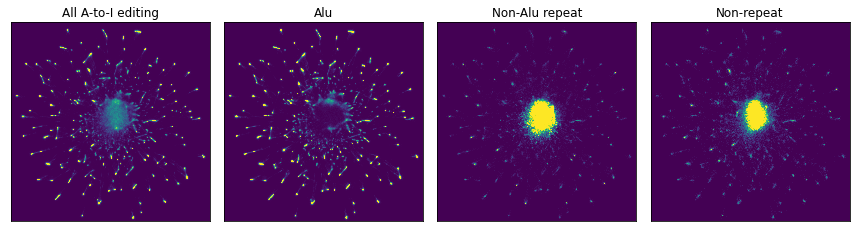

In [10]:
draw_2D_hist(df, "REDIportal_hg38.UMAP.all_together.kmers.png")

## 4. Retrive number of sites

In [12]:
# We did not set a index for sequences, so it is better to get corrdinates from the 21-mers table and store it in a dict
time0 = time.time()
data_XY = {}
def get_xy(row):
    data_XY[row["motif_F10"]] = (row["X"], row["Y"])
df.apply(get_xy, axis=1)
print("Corrdinates loaded into dict: {} sec".format(time.time()-time0))

Corrdinates loaded into dict: 152.39401960372925 sec


In [13]:
indexes = []
Xs = []
Ys = []
def mark_xy(row):
    global indexes, Xs, Ys
    XY = data_XY.get(row["motif_F10"])
    if XY is not None:
        X, Y = XY
        Xs.append(X)
        Ys.append(Y)
        indexes.append(row.name)
time0 = time.time()
df_all = pd.read_csv("./REDIportal_hg38.F10.csv", index_col=None, header=0)
df_all = df_all[["key", "Region", "Position", "Strand", "Ref", "Ed", "type", "repeat", "motif_F10"]]
df_all.apply(mark_xy, axis=1)
df_all.loc[indexes, "X"] = Xs
df_all.loc[indexes, "Y"] = Ys
df_all = df_all.loc[indexes]
print("Original table marked: {} sec".format(time.time()-time0))
print(df_all.shape)
df_all.to_csv("./REDIportal_hg38.F10.retrived.UMAP.csv")

Original table marked: 388.112979888916 sec
(15638644, 11)


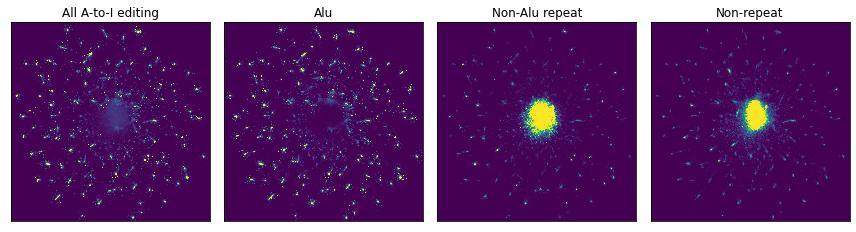

In [14]:
draw_2D_hist(df_all, "REDIportal_hg38.UMAP.all_together.real_count.png")